# License

Copyright (c) 2024 Pranjal Choudhury, Bosanta Ranjan Boruah

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License
as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see <http://www.gnu.org/licenses/>.

######################################################################################################################################


# Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, UpSampling2D, Convolution2D, MaxPooling2D, BatchNormalization, Layer, Add
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, losses
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from scipy.ndimage import gaussian_filter

import os
import numpy as np
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import shutil
import csv
import time

from skimage import measure, filters
import ImageVisualization


# Basic Functionalities

In [2]:
# project image in floating point values between 0 and 1
def project_01(im):
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val)/(max_val - min_val)

# normalize image given mean and std
def normalize_im(im, dmean, dstd):
    im = np.squeeze(im)
    im_norm = np.zeros(im.shape,dtype=np.float32)
    im_norm = (im - dmean)/dstd
    return im_norm

# Define the loss history recorder
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [3]:
def process_test_images(images_):

    X_test = images_.astype('float32')
    #===================== Training set normalization ==========================
    # normalize training images to be in the range [0,1] and calculate the 
    # training set mean and std
    mean_test = np.zeros(X_test.shape[0],dtype=np.float32)
    std_test = np.zeros(X_test.shape[0], dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test[i, :, :] = project_01(X_test[i, :, :])
        mean_test[i] = X_test[i, :, :].mean()
        std_test[i] = X_test[i, :, :].std()

    # resulting normalized training images
    mean_val_test = mean_test.mean()
    std_val_test = std_test.mean()
    X_test_norm = np.zeros(X_test.shape, dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test_norm[i, :, :] = normalize_im(X_test[i, :, :], mean_val_test, std_val_test)

    # patch size
    psize = X_test_norm.shape[1]

    # Reshaping
    X_test_norm = X_test_norm.reshape(X_test.shape[0], psize, psize, 1)

    return X_test_norm

In [4]:
def blob_detection(image, PSF_size, threshold ):

    binary_image = image > threshold
    
    # Label connected components in the binary image
    label_image = measure.label(binary_image)

    # Get the properties of labeled regions (blobs)
    blobs = measure.regionprops(label_image)

    # Set a threshold for the minimum blob size
    min_blob_area = PSF_size**2

    # Filter out small blobs
    filtered_blobs = [blob for blob in blobs if blob.area > min_blob_area]
    centroids = []
    for i in range(len(filtered_blobs)):
        centroids.append(filtered_blobs[i].centroid)
    return np.asarray(centroids)

def minmax_filter(image):
    return (image - image.min())/(image.max() - image.min())*255.

def boundary_(array1, array2, threshold):
    array1_filt =[]
    array2_filt =[]
    for i in range(len(array1)):
        if (array1[i]>threshold) & (array2[i]>threshold) & (array1[i]<array1.max()-threshold) & (array2[i]<array2.max()-threshold):
            array1_filt.append(array1[i])
            array2_filt.append(array2[i])
    return np.array((array1_filt,array2_filt))

# The CNN

In [5]:
def matlab_style_gauss2D(shape=(7,7),sigma=1):

    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h.astype(dtype=K.floatx())
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h.astype('float32')
    return h

# Expand the filter dimensions
psf_heatmap = matlab_style_gauss2D(shape = (7,7),sigma=1)
#psf_heatmap = matlab_style_gauss2D(shape = (7,7),sigma=0.35)
gfilter = tf.reshape(psf_heatmap, [7, 7, 1, 1])


def loss_function(input_shape, norm_ai, weight):

    def bump_mse(heatmap_true, spikes_pred):

        # generate the heatmap corresponding to the predicted spikes
        heatmap_pred = K.conv2d(spikes_pred, gfilter, strides=(1, 1), padding='same')
        
        # heatmaps MSE
        loss_heatmaps = losses.mean_squared_error(heatmap_true,heatmap_pred)
        
        return loss_heatmaps 
    return bump_mse

def compute_norm_ai(input_dim, upsampling_factor, psf_heatmap):
    norm_ai = np.ones((input_dim[0], input_dim[1]), dtype=np.float32)
    matr = np.linalg.norm(psf_heatmap)

    return matr*norm_ai

In [6]:
def conv_bn_relu(nb_filter, rk, ck, name):
    def f(input):
        conv = Convolution2D(nb_filter, kernel_size=(rk, ck), strides=(1,1),\
                               padding="same", use_bias=False,\
                               kernel_initializer="Orthogonal",name='conv-'+name)(input)
        conv_norm = BatchNormalization(name='BN-'+name)(conv)
        conv_norm_relu = Activation(activation = "relu",name='Relu-'+name)(conv_norm)
        return conv_norm_relu
    return f

def residual_block(input_features, nb_filter, rk, ck, name):
    conv1 = conv_bn_relu(nb_filter, rk, ck, name + '_conv1')(input_features)
    conv2 = conv_bn_relu(nb_filter, rk, ck, name + '_conv2')(conv1)
    shortcut = Convolution2D(nb_filter, (1, 1), strides=(1, 1), padding='same')(input_features)
    output = Add()([conv2, shortcut])
    return output

# Define the model architecture
def CNN_with_residue(input, names):
    Features1 = conv_bn_relu(32, 3, 3, names+'F1')(input)
    # pool1 = MaxPooling2D(pool_size=(2, 2), name= names+'Pool1')(Features1)
    Features2 = residual_block(Features1, 64, 3, 3, names+'Res1')
    # pool2 = MaxPooling2D(pool_size=(2, 2), name=names+'Pool2')(Features2)

    Features3 = conv_bn_relu(128, 3, 3, names+'F3')(Features2)
    up1 = UpSampling2D(size=(2, 2), name = names+ 'Up1')(Features3)
    Features4 = conv_bn_relu(64, 3, 3, names+'F4')(up1)
    up2 = UpSampling2D(size=(2, 2),name = names+ 'Up3')(Features4)


    return up2


# Define the Model building for an arbitrary input size
def buildModel(input_dim, initial_learning_rate = 0.001, L0_weight = 1):
    input_ = Input (shape = (input_dim))
    act_ = CNN_with_residue (input_,'CNN')
    density_pred = Convolution2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",\
                                  activation="relu", use_bias = False,\
                                  kernel_initializer="Orthogonal",name='Prediction')(act_)
    model = Model (inputs= input_, outputs=density_pred)
    opt = optimizers.Adam(learning_rate = initial_learning_rate)
    norm_ai = compute_norm_ai(input_dim, 1, psf_heatmap)
    model.compile(optimizer=opt, loss = loss_function(input_dim, norm_ai, L0_weight))
    return model


# Using the trained model
We have the model trained and the CNN and other functionalities set up

please run the cells below for prediction

## load the images

In [7]:
# enter the location of your images
input_images = io.imread('data/sequence-as-stack-MT0.N1.HD-2D-Exp.tif')
(nframes, W, H) = input_images.shape

In [8]:
nframes

2500

## build the model and load weights

In [9]:
model = buildModel((W,H,1))
model.load_weights('model/weights_best.hdf5')

In [10]:
input_images_norm = process_test_images(input_images)

# Prediction

In [11]:
predicted_images = model.predict(input_images_norm)

79/79 [==============================] - 37s 447ms/step


# Super resolved image generation using blob-detection

* check a random image in the stack if the detected molecule centres coincides with the PSF centres in the image (ignore the boundaries for now)
* if not, adjust the paramaters 'threshold' and 'psf_size' and check again 

In [ ]:
threshold = 0.20 # choose a number between 0 and 1
psf_size = 3.2  # choose an appropiate number, represents number of pixels in the PSF

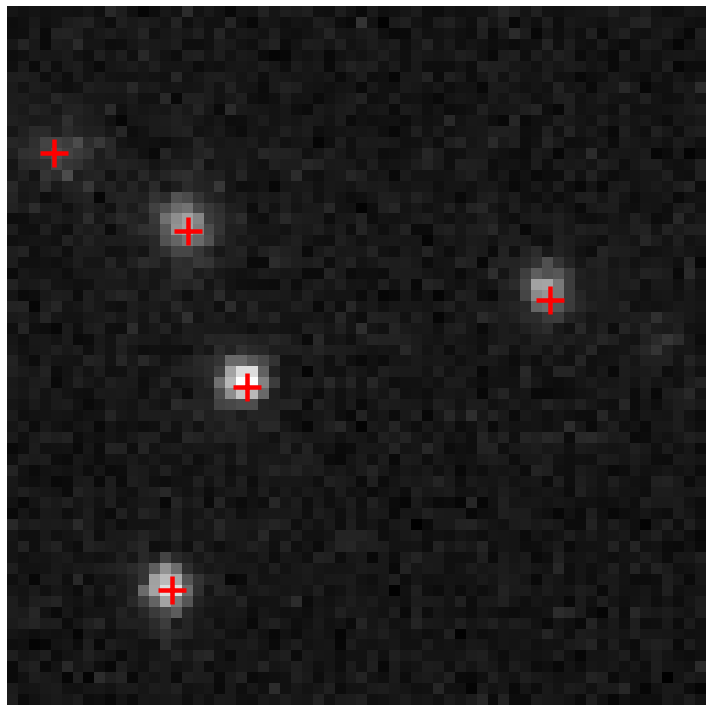

In [16]:
image_number = 72
test_image = predicted_images[image_number]



image = np.where(test_image>threshold*test_image.max(),test_image,0)
image = minmax_filter(image) 
peaks = np.transpose(blob_detection(image, PSF_size=psf_size, threshold=1))

plt.figure(figsize=(10,10))
plt.tight_layout()
plt.imshow(input_images[image_number], cmap ='gray')
plt.scatter(peaks[1]/4, peaks[0]/4, marker = '+', s= 800, color = 'red', linewidths=4.5)
plt.axis('off')
plt.tight_layout()

* if you are satisfied with the detections, you can proceed forward to analyze the whole image stack

In [17]:
detections =[]
for image in predicted_images:
    image = np.where(image>threshold*image.max(),image,0)
    image = minmax_filter(image) 
    peaks = np.transpose(blob_detection(image, PSF_size=psf_size, threshold=1))
    detections.append(peaks)


In [18]:
detection_x = []
detection_y = []

for i in range(len(detections)):
    if len(detections[i])>0:
        for j in range(len(detections[i].T)):
            # print(i,j)
            detection_x.append(detections[i].T[j][0])
            detection_y.append(detections[i].T[j][1])

In [20]:
ash = ImageVisualization.averaged_shifted_histogram(
    (W*4,H*4), detection_y, detection_x, mag = 2.5)

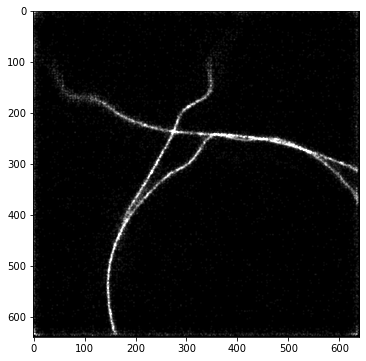

In [21]:
plt.figure(figsize=(6,6))
plt.imshow(ash, cmap='gray', vmax = 0.4*ash.max())


# Saving the super resolved image

If you are satisfied by the output image, you can save it

Otherwise you can revisit the training model, tweak the parameters and try again. You can also tweak the parameters 'threshold' and 'psf_size' above

In [ ]:
im_save = 'data/predicted_super_resolved_image.tif'

io.imsave(im_save, ash)